In [77]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

# EDA

In [41]:
df = pd.read_csv('data/sentiment_analysis.csv')
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [42]:
df.dtypes

Year              int64
Month             int64
Day               int64
Time of Tweet    object
text             object
sentiment        object
Platform         object
dtype: object

In [43]:
df.isnull().sum()

Year             0
Month            0
Day              0
Time of Tweet    0
text             0
sentiment        0
Platform         0
dtype: int64

For this project i will only use the text and the sentiment tag. I don't think the date or the platform are that relevant for text classification.

In [44]:
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative


## Sentiment labels

### Checking different sentiment values

In [45]:
df.sentiment.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

### Checking sentiment distribution

In [46]:
df.sentiment.value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

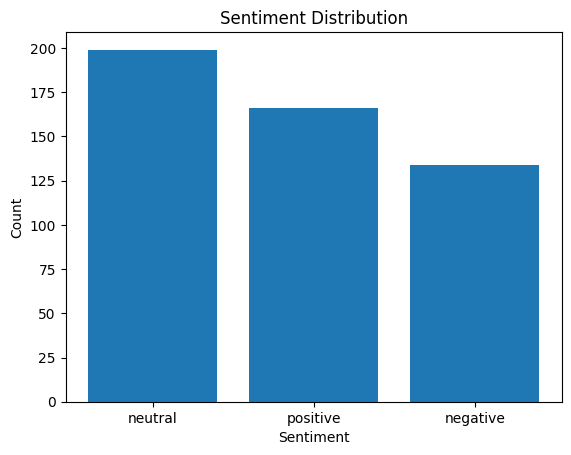

In [47]:
sentiment_count = df.sentiment.value_counts()
plt.bar(sentiment_count.index, sentiment_count.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

### Encoding sentiment labels

In [48]:
label_encoder = LabelEncoder()
label_encoder.fit(df.sentiment)
label_mapping = {label:encoded_label for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
print(label_mapping)

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [49]:
df.sentiment = label_encoder.transform(df.sentiment)

In [50]:
df.head()

,text,sentiment
0,What a great day!!! Looks like dream.,2
1,"I feel sorry, I miss you here in the sea beach",2
2,Don't angry me,0
3,We attend in the class just for listening teac...,0
4,"Those who want to go, let them go",0


## Preprocess text

### Lowercase

In [51]:
df.text = df.text.str.lower()
df.head()

,text,sentiment
0,what a great day!!! looks like dream.,2
1,"i feel sorry, i miss you here in the sea beach",2
2,don't angry me,0
3,we attend in the class just for listening teac...,0
4,"those who want to go, let them go",0


### Remove punctuation marks

In [52]:
df.text = df.text.str.replace('[{}]'.format(string.punctuation), '', regex=True)
df.head()

,text,sentiment
0,what a great day looks like dream,2
1,i feel sorry i miss you here in the sea beach,2
2,dont angry me,0
3,we attend in the class just for listening teac...,0
4,those who want to go let them go,0


### Remove stop words

In [53]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df.text = df.text.apply(lambda t: ' '.join(w for w in t.split() if w not in stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kasteion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
df.head()

,text,sentiment
0,great day looks like dream,2
1,feel sorry miss sea beach,2
2,dont angry,0
3,attend class listening teachers reading slide ...,0
4,want go let go,0


## Validation Framework

In [55]:
from sklearn.model_selection import train_test_split

In [81]:
X = df.text
y = df.sentiment

In [ ]:
df_full_train, df_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=42)

56                                      bad headech need
227                      happy mothers day mothers world
280    getting ready week nice today stuck inside wor...
486                   back soon need run shops cut grass
220             errors red life blue love rose lips baby
Name: text, dtype: object

In [ ]:
df_train.head()

56                                      bad headech need
227                      happy mothers day mothers world
280    getting ready week nice today stuck inside wor...
486                   back soon need run shops cut grass
220             errors red life blue love rose lips baby
Name: text, dtype: object

In [88]:
y_train.head()

434    2
398    0
277    2
37     1
146    2
Name: sentiment, dtype: int64

In [93]:
print(f'Shape of df_train: {df_train.shape}')
print(f'Shape of df_val: {df_val.shape}')
print(f'Shape of df_test: {df_test.shape}')

total_size = len(df_train)+len(df_val)+len(df_test)
print(f'total dataset size: {total_size}')
print(f'train %: {len(df_train)/total_size*100}')
print(f'val %: {len(df_val)/total_size*100}')
print(f'test %: {len(df_test)/total_size*100}')

Shape of df_train: (299,)
Shape of df_val: (100,)
Shape of df_test: (100,)
total dataset size: 499
train %: 59.919839679358724
val %: 20.04008016032064
test %: 20.04008016032064


## Model training

### Logistic regression (Term frequency)

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score

In [90]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=8000)
X_train_counts = count_vectorizer.fit_transform(df_train, y_train)
X_val_counts = count_vectorizer.transform(df_val)
X_test_counts = count_vectorizer.transform(df_test)

In [96]:
print(X_train_counts.shape)
# Calculate the frequencies
word_frequencies = np.array(X_train_counts.sum(axis=0))[0]
# Get the indexes that would sort the word frequencies
sorted_indexes = np.argsort(word_frequencies)
# Get the vocabulary words corresponding to the indexes
vocabulary_words = np.array(count_vectorizer.get_feature_names_out())
# Get the top and bottom frequent words
top_10_tokens = vocabulary_words[sorted_indexes[-10:]][::-1]
bottom_10_tokens = vocabulary_words[sorted_indexes[:10]]

print("Top 10 frequent tokens:")
print(top_10_tokens)

print("\nBottom 10 frequent tokens:")
print(bottom_10_tokens)


(299, 2354)
Top 10 frequent tokens:
['im' 'day' 'go' 'going' 'know' 'love' 'happy' 'like' 'today' 'dont']

Bottom 10 frequent tokens:
['zero funny' 'lol dammit' 'thank teaching' 'logo' 'lobster weekend'
 'lobster' 'lmao smh' 'lmao' 'lm days' 'lm']


In [97]:
clr = LogisticRegression(random_state=42)
clr.fit(X_train_counts, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [111]:
def get_accuracy(clf, X_data_split, y_data_split, split_name):
    y_pred = clf.predict(X_data_split)
    score = accuracy_score(y_data_split, y_pred)
    print(f'Accuracy on {split_name}: {score}')
    return score

def get_auc(clf, X_data_split, y_data_split, split_name):
    y_pred = clf.predict_proba(X_data_split)
    score = roc_auc_score(y_data_split, y_pred, multi_class='ovo')
    print(f'Area under the curve on {split_name}: {score}')
    return score

In [112]:
get_auc(clr, X_train_counts, y_train, 'train')
get_auc(clr, X_val_counts, y_val, 'val')
get_auc(clr, X_test_counts, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.8206397487127491
Area under the curve on test: 0.856454248366013


np.float64(0.856454248366013)

In [113]:
get_accuracy(clr, X_train_counts, y_train, 'train')
get_accuracy(clr, X_val_counts, y_val, 'val')
get_accuracy(clr, X_test_counts, y_test, 'test')

Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.58


0.58

In [148]:
for solver in ['newton-cg', 'newton-cholesky', 'sag', 'saga']:
    clr = LogisticRegression(solver=solver, random_state=42)
    clr.fit(X_train_counts, y_train)

    print(solver, "->")
    get_auc(clr, X_train_counts, y_train, 'train')
    get_auc(clr, X_val_counts, y_val, 'val')
    get_auc(clr, X_test_counts, y_test, 'test')

    get_accuracy(clr, X_train_counts, y_train, 'train')
    get_accuracy(clr, X_val_counts, y_val, 'val')
    get_accuracy(clr, X_test_counts, y_test, 'test')
    print()

newton-cg ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8205055565495716
Area under the curve on test: 0.8566085693536675
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.58

newton-cholesky ->
Area under the curve on train: 1.0
Area under the curve on val: 0.82078885111628
Area under the curve on test: 0.8566085693536675
Accuracy on train: 1.0
Accuracy on val: 0.68
Accuracy on test: 0.58

sag ->
Area under the curve on train: 1.0
Area under the curve on val: 0.8175682392000159
Area under the curve on test: 0.8518881626724765
Accuracy on train: 1.0
Accuracy on val: 0.71
Accuracy on test: 0.62

saga ->
Area under the curve on train: 1.0
Area under the curve on val: 0.815744219796823
Area under the curve on test: 0.8497095134350037
Accuracy on train: 1.0
Accuracy on val: 0.72
Accuracy on test: 0.62



/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kasteion/repos/kasteion/ml-zoomcamp-2025-capstone-1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Logistic regression (TF-IDF)

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [115]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=8000)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train, y_train)
X_val_tfidf = tfidf_vectorizer.transform(df_val)
X_test_tfidf = tfidf_vectorizer.transform(df_test)

In [123]:
tfidflr = LogisticRegression(random_state=42)
tfidflr.fit(X_train_tfidf, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [124]:
get_auc(tfidflr, X_train_tfidf, y_train, 'train')
get_auc(tfidflr, X_val_tfidf, y_val, 'val')
get_auc(tfidflr, X_test_tfidf, y_test, 'test')

Area under the curve on train: 1.0
Area under the curve on val: 0.7947655116200473
Area under the curve on test: 0.8461147421931736


np.float64(0.8461147421931736)

In [125]:
get_accuracy(tfidflr, X_train_tfidf, y_train, 'train')
get_accuracy(tfidflr, X_val_tfidf, y_val, 'val')
get_accuracy(tfidflr, X_test_tfidf, y_test, 'test')

Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58


0.58

In [150]:
for solver in ['newton-cg', 'newton-cholesky', 'sag', 'saga']:
    clr = LogisticRegression(solver=solver, max_iter=500, random_state=42)
    clr.fit(X_train_tfidf, y_train)

    print(solver, "->")
    get_auc(clr, X_train_tfidf, y_train, 'train')
    get_auc(clr, X_val_tfidf, y_val, 'val')
    get_auc(clr, X_test_tfidf, y_test, 'test')

    get_accuracy(clr, X_train_tfidf, y_train, 'train')
    get_accuracy(clr, X_val_tfidf, y_val, 'val')
    get_accuracy(clr, X_test_tfidf, y_test, 'test')
    print()

newton-cg ->
Area under the curve on train: 1.0
Area under the curve on val: 0.794994135305461
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

newton-cholesky ->
Area under the curve on train: 1.0
Area under the curve on val: 0.794994135305461
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

sag ->
Area under the curve on train: 1.0
Area under the curve on val: 0.794994135305461
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

saga ->
Area under the curve on train: 1.0
Area under the curve on val: 0.7950885668276971
Area under the curve on test: 0.8461147421931736
Accuracy on train: 0.9966555183946488
Accuracy on val: 0.69
Accuracy on test: 0.58

